In [13]:
import pandas as pd

data = pd.read_csv('./1024_final.csv')
data

,sensor_id,time,value,upper_limit,lower_limit,outlier_status
0,7,2024-10-24 18:03:24.373432,0.004187,0.015067,0.000025,False
1,7,2024-10-24 18:03:24.093041,0.002991,0.015067,0.000026,False
2,7,2024-10-24 18:03:23.813442,0.006580,0.015066,0.000027,False
3,7,2024-10-24 18:03:23.532844,0.007178,0.015066,0.000027,False
4,7,2024-10-24 18:03:23.253049,0.010468,0.015066,0.000027,False
...,...,...,...,...,...,...
21637,7,2024-10-24 16:22:35.411543,0.007178,0.012931,0.001425,False
21638,7,2024-10-24 16:22:35.130802,0.005084,0.013610,0.000746,False
21639,7,2024-10-24 16:22:34.849425,0.008374,0.010417,0.005334,False
21640,7,2024-10-24 16:22:34.568604,0.007178,0.009869,0.005383,False


---

## 5시그마 (데이터 기반)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임 정렬 (시간 순서 오름차순)
data['time'] = pd.to_datetime(data['time'], format='mixed')
data = data.sort_values(by='time').reset_index(drop=True)

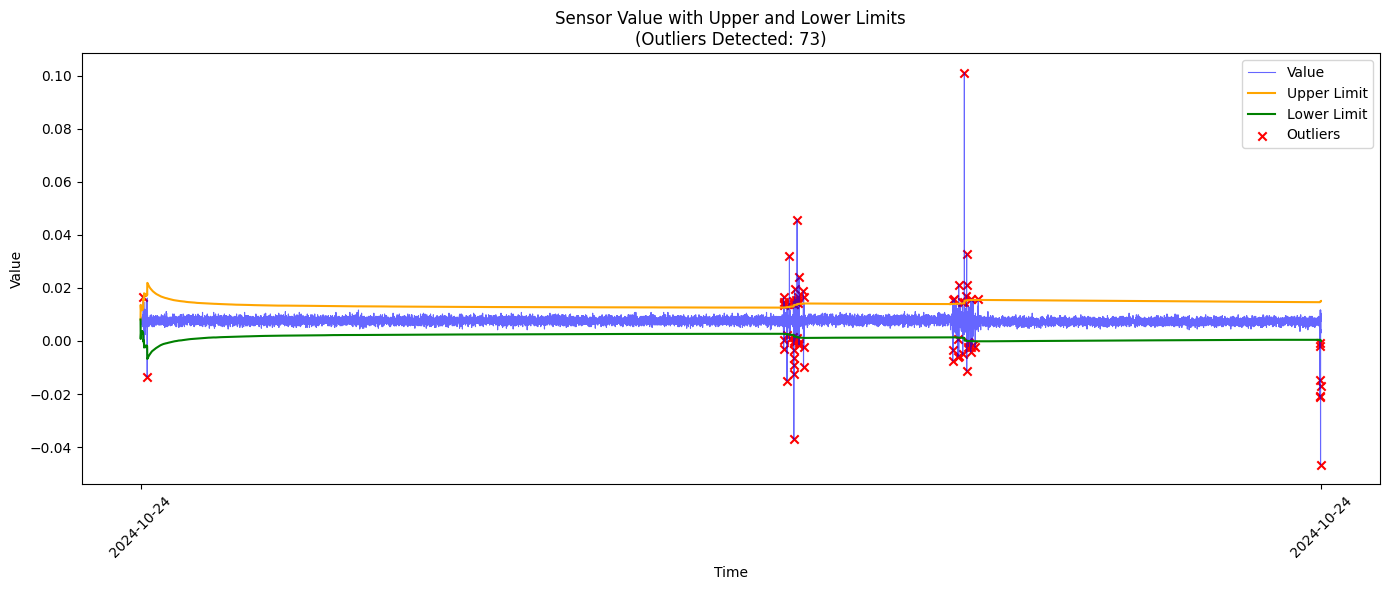

In [15]:
# 이상치 데이터 필터링 (outlier_status가 True인 경우)
outliers = data[data['outlier_status'] == True]

# 시각화
plt.figure(figsize=(14, 6))

# value, upper_limit, lower_limit 그래프 그리기 (모두 실선 표시)
plt.plot(data['time'], data['value'], label='Value', color='blue', linewidth=0.8, alpha=0.6, linestyle='-')
plt.plot(data['time'], data['upper_limit'], label='Upper Limit', color='orange', linestyle='-')
plt.plot(data['time'], data['lower_limit'], label='Lower Limit', color='green', linestyle='-')

# 이상치 점 찍기
plt.scatter(outliers['time'], outliers['value'], color='red', label='Outliers', marker='x')

# 레이블과 제목 설정
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Sensor Value with Upper and Lower Limits\n(Outliers Detected: {len(outliers)})')  # 이상치 개수 표시
plt.legend()

# x축 시간은 처음과 끝의 값만 표시
plt.xticks([data['time'].iloc[0], data['time'].iloc[-1]], rotation=45)

# 그래프 레이아웃 설정
plt.tight_layout()
plt.show()

---

## kalman filter + z-score + 3시그마

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

data = pd.read_csv('./1024_final.csv')

In [2]:
# Kalman 필터 설정
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
state_means, _ = kf.em(data['value'].values, n_iter=5).filter(data['value'].values)
data['filtered_value'] = state_means  # Kalman 필터 적용한 값 추가

# 이동 평균과 표준편차 계산
window = 100  # 이동 평균 및 표준편차를 계산할 윈도우 크기 (현재값 이전 값들 기준)
data['rolling_mean'] = data['filtered_value'].rolling(window=window, min_periods=1).mean()
data['rolling_std'] = data['filtered_value'].rolling(window=window, min_periods=1).std()

# 상한선과 하한선 설정 (+- 3 시그마)
data['upper_limit'] = data['rolling_mean'] + 3 * data['rolling_std']
data['lower_limit'] = data['rolling_mean'] - 3 * data['rolling_std']

# outlier_status 설정 (filtered_value가 상한선 초과 또는 하한선 미만인 경우)
data['outlier_status'] = (data['filtered_value'] > data['upper_limit']) | (data['filtered_value'] < data['lower_limit'])
outliers = data[data['outlier_status']]


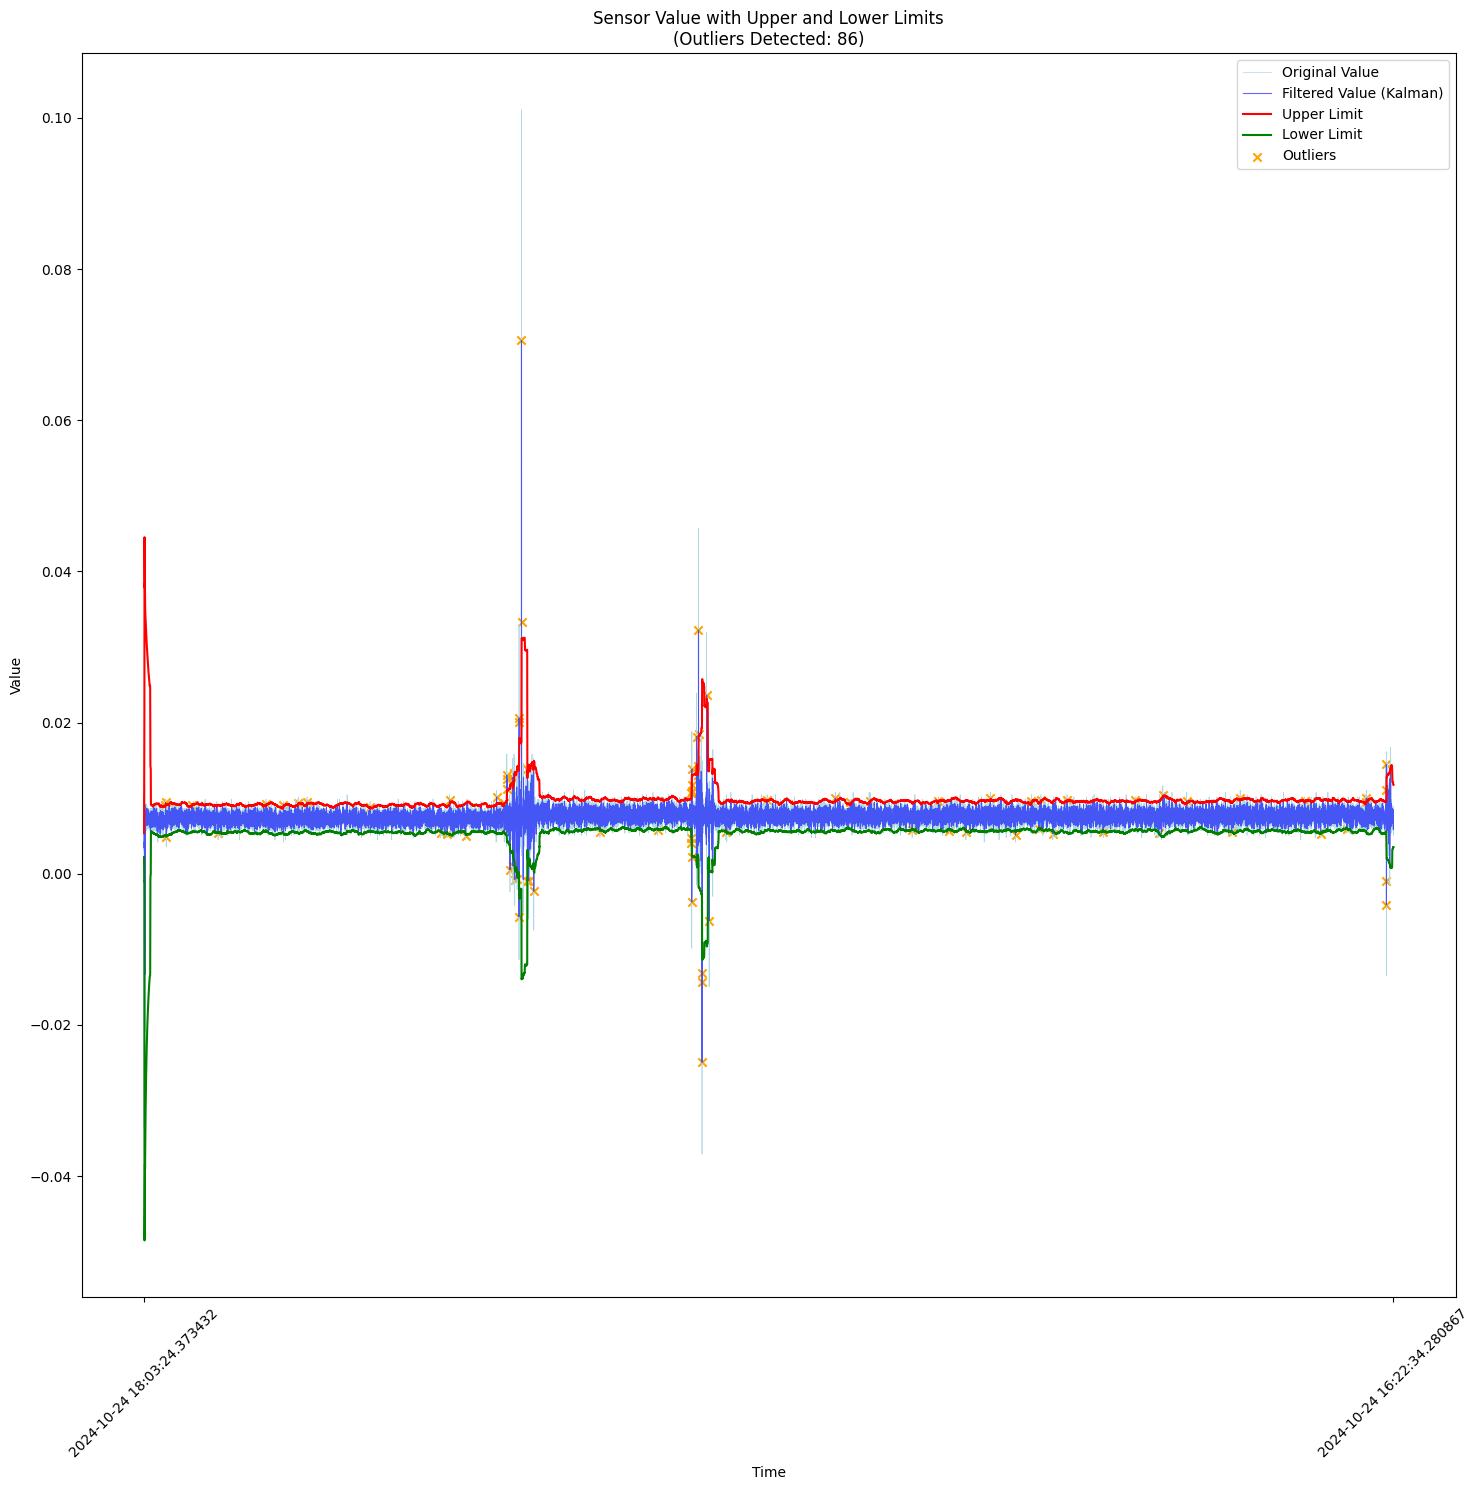

In [5]:
# 시각화
plt.figure(figsize=(15, 15))

# 원본 value, Kalman 필터링된 값, upper_limit, lower_limit 그래프 그리기 (모두 실선 표시)
plt.plot(data['time'], data['value'], label='Original Value', color='lightblue', linewidth=0.5, linestyle='-')
plt.plot(data['time'], data['filtered_value'], label='Filtered Value (Kalman)', color='blue', linewidth=0.8, alpha=0.6, linestyle='-')
plt.plot(data['time'], data['upper_limit'], label='Upper Limit', color='red', linestyle='-')
plt.plot(data['time'], data['lower_limit'], label='Lower Limit', color='green', linestyle='-')

# 이상치 점 찍기
plt.scatter(outliers['time'], outliers['filtered_value'], color='orange', label='Outliers', marker='x')

# 레이블과 제목 설정
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Sensor Value with Upper and Lower Limits\n(Outliers Detected: {len(outliers)})')
plt.legend()

# x축 시간은 처음과 끝의 값만 표시
plt.xticks([data['time'].iloc[0], data['time'].iloc[-1]], rotation=45)

# 그래프 레이아웃 설정
plt.tight_layout()
plt.show()

---

## FFT filter + z-score + 3시그마

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('./1024_final.csv')

In [20]:
# FFT 필터링
def fft_filter(signal, threshold=0.1):
    # FFT 변환
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal))

    # 고주파 성분 제거 (threshold를 기준으로)
    fft_result[np.abs(frequencies) > threshold] = 0

    # IFFT 변환하여 필터링된 신호 얻기
    filtered_signal = np.fft.ifft(fft_result)
    return np.real(filtered_signal)

# FFT 필터 적용
data['filtered_value'] = fft_filter(data['value'].values)

In [21]:
# 이동 평균과 표준편차 계산
window = 100  # 이동 평균 및 표준편차를 계산할 윈도우 크기 (현재값 이전 값들 기준)
data['rolling_mean'] = data['filtered_value'].rolling(window=window, min_periods=1).mean()
data['rolling_std'] = data['filtered_value'].rolling(window=window, min_periods=1).std()

# 상한선과 하한선 설정 (+- 3 시그마)
data['upper_limit'] = data['rolling_mean'] + 3 * data['rolling_std']
data['lower_limit'] = data['rolling_mean'] - 3 * data['rolling_std']

# outlier_status 설정 (filtered_value가 상한선 초과 또는 하한선 미만인 경우)
data['outlier_status'] = (data['filtered_value'] > data['upper_limit']) | (data['filtered_value'] < data['lower_limit'])
outliers = data[data['outlier_status']]

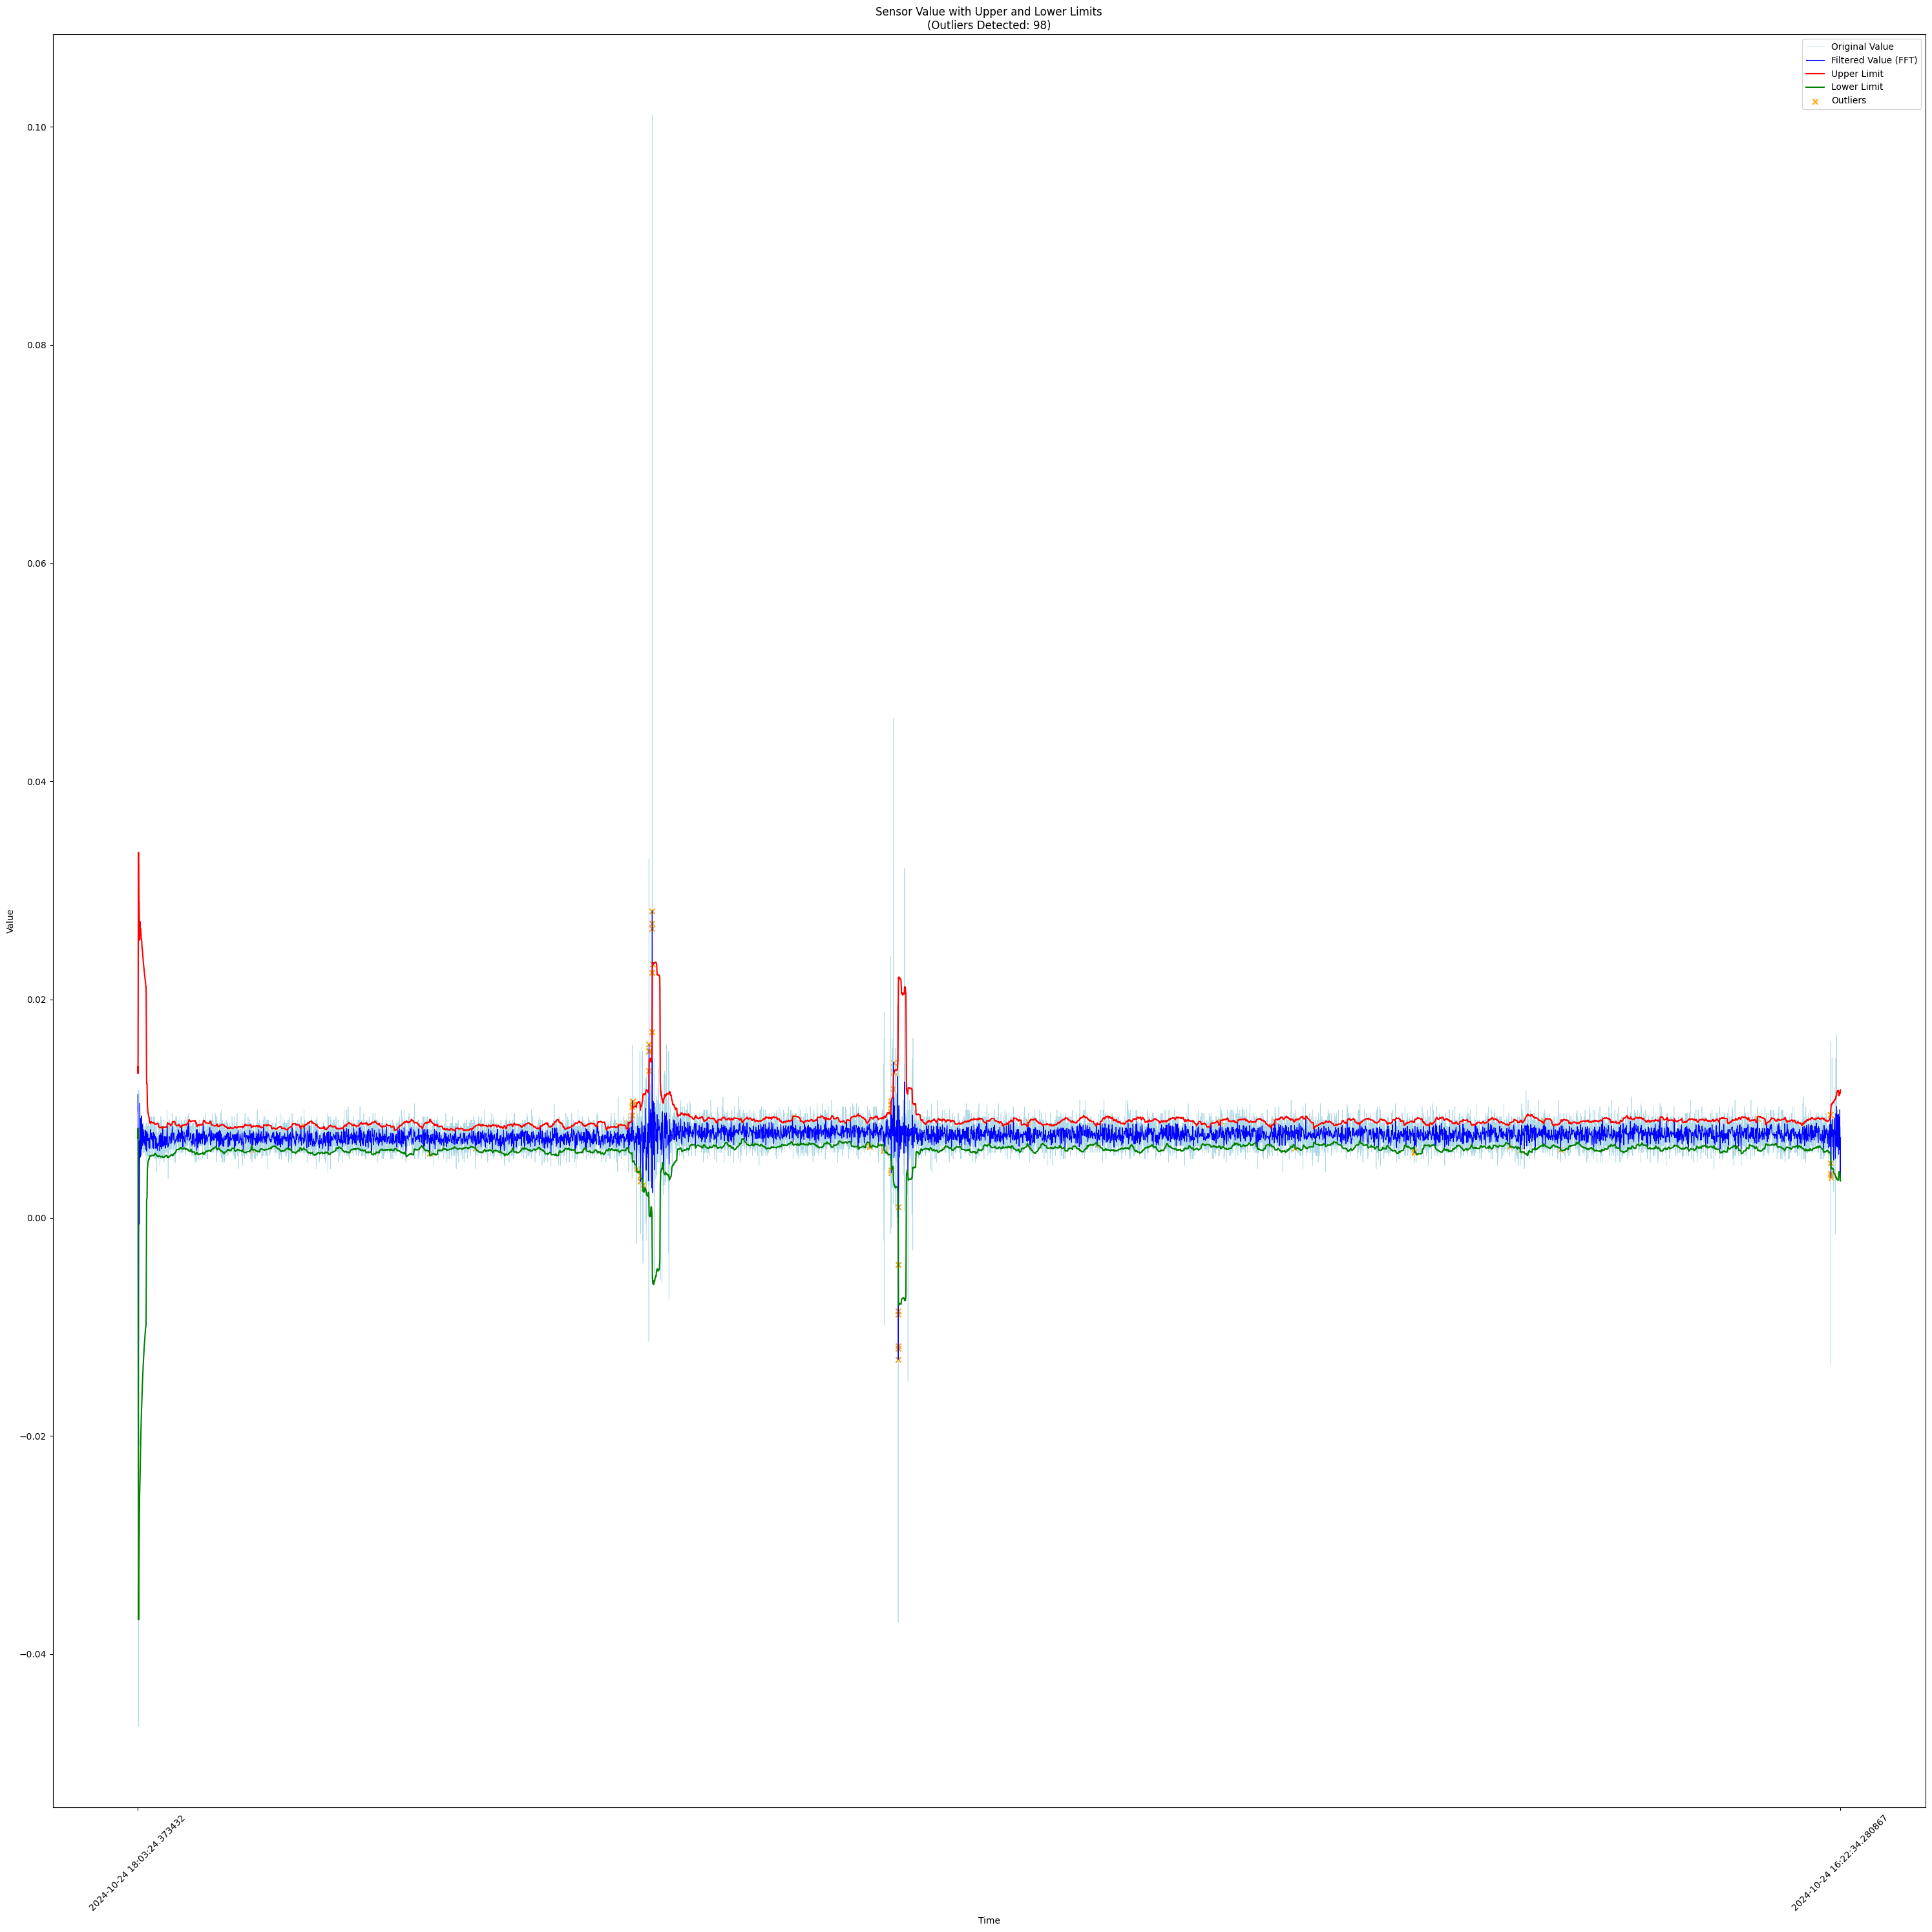

In [22]:
# 시각화
plt.figure(figsize=(30, 30))

# 원본 value, FFT 필터링된 값, upper_limit, lower_limit 그래프 그리기 (모두 실선 표시)
plt.plot(data['time'], data['value'], label='Original Value', color='lightblue', linewidth=0.5, linestyle='-')
plt.plot(data['time'], data['filtered_value'], label='Filtered Value (FFT)', color='blue', linewidth=0.8, linestyle='-')
plt.plot(data['time'], data['upper_limit'], label='Upper Limit', color='red', linestyle='-')
plt.plot(data['time'], data['lower_limit'], label='Lower Limit', color='green', linestyle='-')

# 이상치 점 찍기
plt.scatter(outliers['time'], outliers['filtered_value'], color='orange', label='Outliers', marker='x')

# 레이블과 제목 설정
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Sensor Value with Upper and Lower Limits\n(Outliers Detected: {len(outliers)})')
plt.legend()

# x축 시간은 처음과 끝의 값만 표시
plt.xticks([data['time'].iloc[0], data['time'].iloc[-1]], rotation=45)

# 그래프 레이아웃 설정
plt.tight_layout()
plt.show()

---

## kalman filter VS FFT filter

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [9]:
data = pd.read_csv('./1024_final.csv')
data

,sensor_id,time,value,upper_limit,lower_limit,outlier_status
0,7,2024-10-24 18:03:24.373432,0.004187,0.015067,0.000025,False
1,7,2024-10-24 18:03:24.093041,0.002991,0.015067,0.000026,False
2,7,2024-10-24 18:03:23.813442,0.006580,0.015066,0.000027,False
3,7,2024-10-24 18:03:23.532844,0.007178,0.015066,0.000027,False
4,7,2024-10-24 18:03:23.253049,0.010468,0.015066,0.000027,False
...,...,...,...,...,...,...
21637,7,2024-10-24 16:22:35.411543,0.007178,0.012931,0.001425,False
21638,7,2024-10-24 16:22:35.130802,0.005084,0.013610,0.000746,False
21639,7,2024-10-24 16:22:34.849425,0.008374,0.010417,0.005334,False
21640,7,2024-10-24 16:22:34.568604,0.007178,0.009869,0.005383,False


In [10]:
# 칼만 필터 구현
def kalman_filter(values):
    n = len(values)
    q = 1e-5  # 프로세스 잡음 공분산
    r = 0.1   # 측정 잡음 공분산

    xhat = 0  # 초기 상태 추정
    p = 1.0   # 초기 공분산
    xhat_arr = np.zeros(n)

    for k in range(n):
        # 예측 단계
        xhat = xhat  # 상태 예측
        p = p + q  # 공분산 예측

        # 업데이트 단계
        kf = p / (p + r)  # 칼만 이득
        xhat = xhat + kf * (values[k] - xhat)  # 상태 업데이트
        p = (1 - kf) * p  # 공분산 업데이트

        xhat_arr[k] = xhat  # 결과 저장

    return xhat_arr

In [11]:
# FFT 필터 구현
def fft_filter(values):
    # FFT 변환
    fft_values = np.fft.fft(values)
    freq = np.fft.fftfreq(len(values))

    # 저주파 대역 필터링 (예시)
    threshold = 0.1
    fft_values[np.abs(freq) > threshold] = 0  # 고주파 제거

    # 역 FFT 변환
    filtered_values = np.fft.ifft(fft_values)
    return np.real(filtered_values)  # 실수부 반환

In [12]:
# 원본 데이터
original_values = data['value'].values

# 칼만 필터링
data['kalman_filtered'] = kalman_filter(original_values)  # Kalman 필터 적용
data['kalman_filtered'] = data['kalman_filtered'].ffill()  # NaN 처리

# FFT 필터링
data['fft_filtered'] = fft_filter(original_values)  # FFT 필터 적용
data['fft_filtered'] = data['fft_filtered'].ffill()  # NaN 처리

# RMSE 계산
rmse_kalman = np.sqrt(mean_squared_error(original_values, data['kalman_filtered']))
rmse_fft = np.sqrt(mean_squared_error(original_values, data['fft_filtered']))

# RMSE 출력
print(f'Kalman Filter RMSE: {rmse_kalman:.6f}')
print(f'FFT Filter RMSE: {rmse_fft:.6f}')

# 이상치 개수 출력
outliers_kalman = data[(data['kalman_filtered'] > data['upper_limit']) | (data['kalman_filtered'] < data['lower_limit'])].shape[0]
outliers_fft = data[(data['fft_filtered'] > data['upper_limit']) | (data['fft_filtered'] < data['lower_limit'])].shape[0]

print(f'Kalman Filter Outliers: {outliers_kalman}')
print(f'FFT Filter Outliers: {outliers_fft}')

Kalman Filter RMSE: 0.001470
FFT Filter RMSE: 0.001276
Kalman Filter Outliers: 18
FFT Filter Outliers: 34


**>> RMSE 값이 낮을수록 원본 데이터와 필터링된 데이터 간의 차이가 작다는 것을 의미하므로, FFT 필터가 더 좋은 성능을 보임.**

---